In [1]:
# Cell-1
# CAVECLIENT + CLOUDVOLUME SETUP
# Following the official MICrONS documentation

# =============================================================================
# STEP 1: INSTALL REQUIRED PACKAGES
# =============================================================================

import subprocess
import sys

def install_microns_packages():
    """Install CAVEclient, CloudVolume, and ImageryClient"""

    packages = [
        "caveclient",
        "cloud-volume",
        "imageryclient"
    ]

    print("Installing MICrONS data access packages...")
    for package in packages:
        try:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
            print(f"Successfully installed {package}")
        except Exception as e:
            print(f"Failed to install {package}: {e}")

    print("Installation complete")

# Install packages
install_microns_packages()

# =============================================================================
# STEP 2: SETUP CAVECLIENT TOKEN (REQUIRED FOR CLOUDVOLUME)
# =============================================================================

def setup_cave_token():
    """Setup CAVEclient token - required for CloudVolume access"""

    print("\nSETTING UP CAVECLIENT TOKEN")
    print("=" * 40)
    print("This is required for CloudVolume to work with MICrONS data")

    from caveclient import CAVEclient

    # Check if token already exists
    try:
        client = CAVEclient()
        current_token = client.auth.token

        if current_token:
            print(f"Found existing token: {current_token[:20]}...")

            # Test if it works
            try:
                test_client = CAVEclient('minnie65_public')
                print("Token works for minnie65_public")
                return test_client
            except Exception as e:
                print(f"Token exists but may not work: {e}")
                print("Let's set up a fresh token...")
        else:
            print("No token found, setting up new token...")

    except Exception as e:
        print(f"No existing setup found: {e}")

    # Setup new token
    print("\nSetting up new token...")
    print("This will open a browser window")

    try:
        client = CAVEclient()

        # Get new token
        print("1. Getting token setup instructions...")
        client.auth.setup_token(make_new=True)

        print("\n" + "="*50)
        print("BROWSER WINDOW SHOULD HAVE OPENED")
        print("="*50)
        print("1. Log in with your Gmail account")
        print("2. Copy the token from the webpage")
        print("3. Come back here and paste it below")
        print("="*50)

        # Get token from user
        token = input("\nPaste your token here: ").strip()

        if token:
            # Save token
            client.auth.save_token(token=token, overwrite=True)
            print(f"Token saved: {client.auth.token[:20]}...")

            # Test token
            test_client = CAVEclient('minnie65_public')
            print("Token works for minnie65_public")

            return test_client
        else:
            print("No token provided")
            return None

    except Exception as e:
        print(f"Token setup failed: {e}")
        return None

# =============================================================================
# STEP 3: PROPER CLOUDVOLUME SETUP USING CAVECLIENT
# =============================================================================

def setup_proper_cloudvolume(client):
    """Setup CloudVolume using CAVEclient info - the official way"""

    print("\nSETTING UP CLOUDVOLUME WITH CAVECLIENT")
    print("=" * 45)

    try:
        from cloudvolume import CloudVolume

        # Get official data sources from CAVEclient
        print("Getting official data sources from CAVEclient...")

        image_source = client.info.image_source()
        seg_source = client.info.segmentation_source()

        print(f"Image source: {image_source}")
        print(f"Segmentation source: {seg_source}")

        # Initialize CloudVolume with official sources
        print("Initializing CloudVolume with official sources...")

        # EM volume
        em_vol = CloudVolume(image_source, progress=False, use_https=True)
        print(f"EM CloudVolume initialized")
        print(f"  Resolution: {em_vol.resolution}")
        print(f"  Bounds: {em_vol.bounds}")

        # Segmentation volume
        seg_vol = CloudVolume(seg_source, progress=False, use_https=True)
        print(f"Segmentation CloudVolume initialized")

        return em_vol, seg_vol

    except Exception as e:
        print(f"CloudVolume setup failed: {e}")
        return None, None

# =============================================================================
# STEP 4: IMAGERYCLIENT
# =============================================================================

def setup_imagery_client(client):
    """Setup ImageryClient - recommended for aligned downloads"""

    print("\nSETTING UP IMAGERYCLIENT (RECOMMENDED)")
    print("=" * 45)

    try:
        import imageryclient as ic

        # Initialize ImageryClient with CAVEclient
        img_client = ic.ImageryClient(client=client)

        print("ImageryClient initialized")
        print("Ready for aligned imagery and segmentation downloads")

        return img_client

    except Exception as e:
        print(f"ImageryClient setup failed: {e}")
        return None

# =============================================================================
# STEP 5: TEST DATA ACCESS
# =============================================================================

def test_data_access(client, em_vol=None, seg_vol=None, img_client=None):
    """Test that data access is working"""

    print("\nTESTING DATA ACCESS")
    print("=" * 25)

    # Test 1: Basic client info
    try:
        info = client.info.get_datastack_info()
        print(f"Datastack info: {info.get('datastack_name', 'Unknown')}")
    except Exception as e:
        print(f"Datastack info failed: {e}")

    # Test 2: CloudVolume download
    if em_vol and seg_vol:
        try:
            print("Testing CloudVolume download...")

            # Small test download
            bounds = em_vol.bounds
            test_bbox = [
                slice(bounds.minpt.z + 100, bounds.minpt.z + 116),
                slice(bounds.minpt.y + 1000, bounds.minpt.y + 1064),
                slice(bounds.minpt.x + 1000, bounds.minpt.x + 1064)
            ]

            em_patch = em_vol[test_bbox]
            seg_patch = seg_vol[test_bbox]

            print(f"CloudVolume download successful")
            print(f"  EM patch shape: {em_patch.shape}")
            print(f"  Seg patch shape: {seg_patch.shape}")

        except Exception as e:
            print(f"CloudVolume download failed: {e}")

    # Test 3: ImageryClient download
    if img_client:
        try:
            print("Testing ImageryClient download...")

            # Test coordinates
            ctr = [240640, 207872, 21360]

            image, segs = img_client.image_and_segmentation_cutout(
                ctr,
                split_segmentations=True,
                bbox_size=(128, 128),  # Smaller for testing
                scale_to_bounds=True,
            )

            print(f"ImageryClient download successful")
            print(f"  Image shape: {image.shape}")
            print(f"  Segmentations: {len(segs)} objects")

        except Exception as e:
            print(f"ImageryClient download failed: {e}")

# =============================================================================
# RUN THE COMPLETE SETUP
# =============================================================================

def run_complete_setup():
    """Run the complete proper setup"""

    print("PROPER MICRONS DATA ACCESS SETUP")
    print("=" * 50)
    print("Following official MICrONS documentation")

    # Step 1: Setup CAVEclient token
    client = setup_cave_token()

    if not client:
        print("\nCAVEclient setup failed")
        print("Cannot proceed without proper token")
        return None

    # Step 2: Setup CloudVolume
    em_vol, seg_vol = setup_proper_cloudvolume(client)

    # Step 3: Setup ImageryClient
    img_client = setup_imagery_client(client)

    # Step 4: Test everything
    test_data_access(client, em_vol, seg_vol, img_client)

    if em_vol or img_client:
        print(f"\nSUCCESS! Proper MICrONS data access setup complete!")
        print(f"CAVEclient authenticated")
        print(f"CloudVolume and/or ImageryClient working")
        print(f"Ready to collect real MICrONS data")

        return {
            'client': client,
            'em_vol': em_vol,
            'seg_vol': seg_vol,
            'img_client': img_client
        }
    else:
        print(f"\nSetup partially failed")
        print(f"Token works but data access has issues")
        return {'client': client}

# Run the setup
print("Starting proper MICrONS setup...")
setup_result = run_complete_setup()

if setup_result:
    if 'em_vol' in setup_result and setup_result['em_vol']:
        print("\nCloudVolume method available")
        print("You can now collect real MICrONS data using CloudVolume")

    if 'img_client' in setup_result and setup_result['img_client']:
        print("\nImageryClient method available")
        print("You can now collect real MICrONS data using ImageryClient")

    print("\nNext: Use these authenticated clients to collect synapse data")
else:
    print("\nSetup failed - consider Google Colab for better cloud access")

Installing MICrONS data access packages...
Installing caveclient...
Installing cloud-volume...
Installing imageryclient...
Installation complete
Starting proper MICrONS setup...
PROPER MICRONS DATA ACCESS SETUP
Following official MICrONS documentation

SETTING UP CAVECLIENT TOKEN
This is required for CloudVolume to work with MICrONS data
Found existing token: 7ff02c93ccd718517769...
Token works for minnie65_public

SETTING UP CLOUDVOLUME WITH CAVECLIENT
Getting official data sources from CAVEclient...
Image source: precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/em
Segmentation source: graphene://https://minnie.microns-daf.com/segmentation/table/minnie65_public
Initializing CloudVolume with official sources...
EM CloudVolume initialized
  Resolution: [ 8  8 40]
  Bounds: Bbox([13824, 13824, 14816],[226816, 194048, 27904], dtype=np.int32, unit='vx')
Segmentation CloudVolume initialized

SETTING UP IMAGERYCLIENT (RECOMMENDED)
ImageryClient initialize

In [2]:
# Copy and paste this token in if asked to
print("7ff02c93ccd718517769fef622d3026e")

7ff02c93ccd718517769fef622d3026e


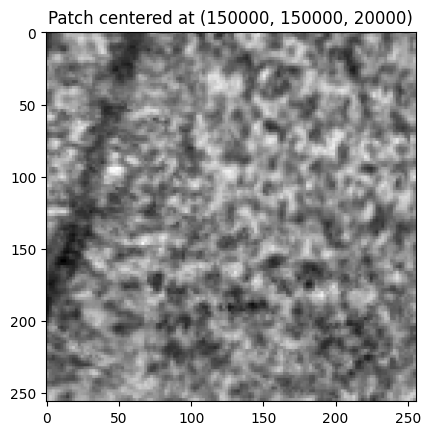

In [3]:
from imageryclient import ImageryClient
img_client = setup_result['img_client']

# Example (Just to test getting image works): get 2D patch 
# centered at some coordinate
center = (150000, 150000, 20000)  # x, y, z coordinates
image, segments = img_client.image_and_segmentation_cutout(
    center,
    bbox_size=(256, 256),   # patch size in pixels
    scale_to_bounds=True
)

# Save or visualize it
import matplotlib.pyplot as plt
plt.imshow(image, cmap='gray')
plt.title(f'Patch centered at {center}')
plt.show()


In [4]:
from caveclient import CAVEclient
client = CAVEclient('minnie65_public')

# Getting dataframe of neurons from allen_v1. This table has excitatory & inhibitory neuron classifications
# done manually by some anatomists of the Allen Institute
df_neurons = client.materialize.query_table('allen_v1_column_types_slanted_ref')
print(df_neurons.shape)

# Filter to only excitatory and inhibitory neurons
df_neurons = df_neurons[df_neurons['classification_system'].isin(
    ['aibs_coarse_excitatory', 'aibs_coarse_inhibitory']
)]

# Simplify label to binary
df_neurons['label'] = df_neurons['classification_system'].apply(
    lambda x: 'excitatory' if 'excitatory' in x else 'inhibitory'
)

print(df_neurons[['pt_root_id', 'label']].head())
print("Total labeled neurons:", len(df_neurons))

print(df_neurons.shape)

(1357, 15)
           pt_root_id       label
0  864691136968429774  excitatory
1  864691135164434989  excitatory
2  864691135778954848  excitatory
3  864691135694415551  excitatory
4  864691135778773856  inhibitory
Total labeled neurons: 1352
(1352, 16)


In [5]:
import pandas as pd
from caveclient import CAVEclient


# Sample a few neurons from each class (to avoid downloading too much)
sample_n_exc = 20
sample_n_inh = 20
exc_neurons = df_neurons[df_neurons['label'] == 'excitatory'].sample(sample_n_exc, random_state=42)
inh_neurons = df_neurons[df_neurons['label'] == 'inhibitory'].sample(sample_n_inh, random_state=42)
print(exc_neurons.head())

# Helper function to download synapses for a list of neurons
def fetch_synapses_for_neurons(neuron_ids, label):
    syn_dfs = []
    for nid in neuron_ids:
        try:
            syn_df = client.materialize.synapse_query(pre_ids=[int(nid)])
            if syn_df is not None and len(syn_df) > 0:
                syn_df['label'] = label  # label by pre-neuron type
                syn_df['pre_root_id'] = nid
                syn_dfs.append(syn_df)
        except Exception as e:
            print(f"Failed for neuron {nid}: {e}")
    return pd.concat(syn_dfs, ignore_index=True) if syn_dfs else pd.DataFrame()

# Download a subset of synapses for both types
print("Downloading excitatory synapses...")
exc_syn = fetch_synapses_for_neurons(exc_neurons['pt_root_id'], 'excitatory')
print(exc_syn.shape)

print("Downloading inhibitory synapses...")
inh_syn = fetch_synapses_for_neurons(inh_neurons['pt_root_id'], 'inhibitory')
print(inh_syn.shape)

# Combine into one dataset
all_synapses = pd.concat([exc_syn, inh_syn], ignore_index=True)
print("Combined synapse dataset shape:", all_synapses.shape)


      id_ref                      created_ref  valid_ref      volume  \
363   256615 2020-09-28 22:42:15.656846+00:00       True  347.231689   
1316  292667 2020-09-28 22:45:21.223376+00:00       True   387.41098   
1029  296666 2020-09-28 22:44:52.054102+00:00       True  291.998108   
102   294591 2020-09-28 22:41:10.193234+00:00       True   228.15834   
1061  258363 2020-09-28 22:44:55.825539+00:00       True  298.531555   

       pt_supervoxel_id          pt_root_id    id  \
363   88673414696959245  864691135347633055   210   
1316  90571721320546579  864691135464128062   387   
1029  90998950374685809  864691137055367798  1246   
102   91068219607203505  864691136579129876   120   
1061  88464026384178323  864691135742756203   149   

                              created  valid  target_id  \
363  2023-03-18 14:13:21.724630+00:00   True     256615   
1316 2023-03-18 14:13:21.993277+00:00   True     292667   
1029 2023-03-18 14:13:22.592300+00:00   True     296666   
102  2023-03

In [6]:
print(all_synapses.head)

<bound method NDFrame.head of               id                          created  superceded_id  valid  \
0      210802808 2020-11-04 13:12:24.144507+00:00           <NA>   True   
1      124587416 2020-11-04 06:49:11.546047+00:00           <NA>   True   
2      126709282 2020-11-04 06:51:43.391792+00:00           <NA>   True   
3      114222147 2020-11-04 06:48:59.326085+00:00           <NA>   True   
4      101887084 2020-11-04 06:58:26.675701+00:00           <NA>   True   
...          ...                              ...            ...    ...   
56330  168321615 2020-11-04 11:23:48.257948+00:00           <NA>   True   
56331  198822093 2020-11-04 08:21:13.152044+00:00           <NA>   True   
56332  201618089 2020-11-04 10:11:52.795220+00:00           <NA>   True   
56333  174316060 2020-11-04 08:48:02.946027+00:00           <NA>   True   
56334  158769336 2020-11-04 08:23:05.986642+00:00           <NA>   True   

          size  pre_pt_supervoxel_id      pre_pt_root_id  \
0      11

In [7]:
# Unique neuron IDs and synapse counts of all_synapses
counts = (
    all_synapses
    # The pre_root id is the neuron
    .groupby('pre_root_id')
    .size()
    .reset_index(name='num_synapses')
    .sort_values('num_synapses', ascending=False)
)

print(counts)
print("Number of unique neurons:", len(counts))

           pre_root_id  num_synapses
30  864691136010404012          6620
18  864691135584019053          5093
25  864691135927509716          4533
16  864691135572963309          4136
13  864691135511861968          3865
19  864691135701557115          3488
27  864691135946994785          2930
23  864691135839577235          2542
15  864691135571427462          2514
8   864691135384209131          2381
28  864691136005322698          1939
38  864691136968109774          1499
4   864691135323181212          1456
33  864691136274933950          1439
0   864691135164283693          1430
14  864691135562842337          1243
1   864691135196035882           780
6   864691135360300632           664
17  864691135573276197           638
7   864691135375655880           563
12  864691135503004765           512
22  864691135808999965           493
37  864691136579129876           486
26  864691135941112998           464
31  864691136091532855           461
9   864691135387516757           453
2

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Function for allocating the train, val, test datasets based on neurons and their synapses
# to prevent data leakage between the sets.
def make_neuron_split_and_sample(
    all_synapses,
    train_frac=0.7, # Train split of unique neurons
    val_frac=0.15,  # Val split
    test_frac=0.15, # Test split
    target_per_class_train=1500, # 1500 excit, 1500 inhib synapse
    target_per_class_val=225, # 225 excit, 225 inhib synapse
    target_per_class_test=225, # 225 excit, 225 inhib synapse
    cap_per_neuron=None,           # e.g. 100 to avoid domination, or None
    random_state=42
):
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-6

    rng = np.random.RandomState(random_state)

    # 1) Unique neurons by class
    neurons = all_synapses[['pre_root_id','label']].drop_duplicates()
    exc_neurons = neurons[neurons['label']=='excitatory']['pre_root_id'].values
    inh_neurons = neurons[neurons['label']=='inhibitory']['pre_root_id'].values

    # 2) Shuffle + split neurons for each class independently (keeps class presence in each split)
    def split_neurons(arr):
        arr = np.array(arr)
        rng.shuffle(arr)
        n = len(arr)
        n_train = int(np.round(train_frac * n))
        n_val = int(np.round(val_frac * n))
        # remaining to test
        n_test = n - n_train - n_val
        train = arr[:n_train]
        val = arr[n_train:n_train+n_val]
        test = arr[n_train+n_val:]
        return train, val, test

    exc_train, exc_val, exc_test = split_neurons(exc_neurons)
    inh_train, inh_val, inh_test = split_neurons(inh_neurons)

    # Helper to sample synapses for a list of neurons to get up to target_count per class
    def sample_synapses_for_split(neuron_list, label, target_count):
        sub = all_synapses[(all_synapses['pre_root_id'].isin(neuron_list)) & (all_synapses['label']==label)].copy()
        if sub.empty:
            return sub.sample(0)  # empty DF with same columns

        # Optionally cap per neuron
        if cap_per_neuron is not None:
            pieces = []
            for nid, group in sub.groupby('pre_root_id'):
                n_take = min(len(group), cap_per_neuron)
                pieces.append(group.sample(n_take, random_state=rng.randint(0, 2**31-1)))
            sub = pd.concat(pieces, ignore_index=True)

        # If there are more synapses than target_count, sample them randomly
        if len(sub) > target_count:
            sub = sub.sample(n=target_count, random_state=rng.randint(0, 2**31-1))
        # If less, return all and warn
        if len(sub) < target_count:
            print(f"WARNING: only {len(sub)} synapses available for label={label} in this split (target {target_count})")
        return sub.reset_index(drop=True)

    # 3) Sample per split and per class
    train_exc = sample_synapses_for_split(exc_train, 'excitatory', target_per_class_train)
    train_inh = sample_synapses_for_split(inh_train, 'inhibitory', target_per_class_train)

    val_exc = sample_synapses_for_split(exc_val, 'excitatory', target_per_class_val)
    val_inh = sample_synapses_for_split(inh_val, 'inhibitory', target_per_class_val)

    test_exc = sample_synapses_for_split(exc_test, 'excitatory', target_per_class_test)
    test_inh = sample_synapses_for_split(inh_test, 'inhibitory', target_per_class_test)

    # 4) Combine
    train_df = pd.concat([train_exc, train_inh], ignore_index=True).sample(frac=1, random_state=random_state).reset_index(drop=True)
    val_df = pd.concat([val_exc, val_inh], ignore_index=True).sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_df = pd.concat([test_exc, test_inh], ignore_index=True).sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Summary counts
    print("Final counts (train/val/test):")
    print("train:", train_df['label'].value_counts().to_dict())
    print("val:  ", val_df['label'].value_counts().to_dict())
    print("test: ", test_df['label'].value_counts().to_dict())

    return {
        'train': train_df,
        'val': val_df,
        'test': test_df,
        'neuron_splits': {
            'exc_train': exc_train, 'exc_val': exc_val, 'exc_test': exc_test,
            'inh_train': inh_train, 'inh_val': inh_val, 'inh_test': inh_test
        }
    }

In [9]:
splits = make_neuron_split_and_sample(all_synapses)
train_df = splits['train']
val_df   = splits['val']
test_df  = splits['test']

Final counts (train/val/test):
train: {'inhibitory': 1500, 'excitatory': 1500}
val:   {'inhibitory': 225, 'excitatory': 225}
test:  {'inhibitory': 225, 'excitatory': 225}


In [10]:
# Unique neuron IDs and synapse counts of training set
counts = (
    train_df
    .groupby('pre_root_id')
    .size()
    .reset_index(name='num_synapses')
    .sort_values('num_synapses', ascending=False)
)

print(counts)
print("Number of unique neurons:", len(counts))

           pre_root_id  num_synapses
0   864691135164283693           330
23  864691136010404012           263
13  864691135584019053           186
19  864691135927509716           180
11  864691135572963309           168
12  864691135573276197           154
9   864691135511861968           137
14  864691135701557115           136
16  864691135808999965           117
24  864691136091532855           103
20  864691135941112998           102
21  864691135946994785           101
17  864691135839577235            98
26  864691136579129876            98
10  864691135571427462            97
5   864691135387516757            91
18  864691135874901134            89
4   864691135384209131            86
15  864691135720061233            85
6   864691135464128062            77
27  864691137055367798            74
2   864691135347633055            66
22  864691136010027182            64
1   864691135257689519            50
3   864691135375655880            24
8   864691135503004765            19
7

In [11]:
# Unique neuron IDs and synapse counts of validation set
counts = (
    val_df
    .groupby('pre_root_id')
    .size()
    .reset_index(name='num_synapses')
    .sort_values('num_synapses', ascending=False)
)

print(counts)
print("Number of unique neurons:", len(counts))

          pre_root_id  num_synapses
4  864691136274933950           131
2  864691135360300632           125
0  864691135196035882            65
3  864691135742756203            63
5  864691136392355711            37
1  864691135293398284            29
Number of unique neurons: 6


In [12]:
# Unique neuron IDs and synapse counts of test set
counts = (
    test_df
    .groupby('pre_root_id')
    .size()
    .reset_index(name='num_synapses')
    .sort_values('num_synapses', ascending=False)
)

print(counts)
print("Number of unique neurons:", len(counts))

          pre_root_id  num_synapses
1  864691135562842337           162
2  864691136005322698            97
0  864691135323181212            70
5  864691136968109774            58
3  864691136452609023            53
4  864691136488591378            10
Number of unique neurons: 6


In [13]:
import os
import matplotlib.pyplot as plt
from imageryclient import ImageryClient

# This section/cell here is the part that saves the image of each synapse and puts them
# in their respective directories (excit or inhib & train, val, or test folder)


img_client = setup_result['img_client']   # already created earlier

# ============================================================
# Create directory structure of dataset
# ============================================================

base_dir = "synapse_patches_512"
splits = ["train", "val", "test"]
labels = ["excitatory", "inhibitory"]

for split in splits:
    for lbl in labels:
        os.makedirs(os.path.join(base_dir, split, lbl), exist_ok=True)


# ============================================================
# Helper function to save a single synapse patch
# ============================================================

def save_synapse_patch(row, split, label, idx):
    center = row["pre_pt_position"]  # (x,y,z) location of synapse
    img_width = 512

    try:
        image, seg = img_client.image_and_segmentation_cutout(
            center,
            bbox_size=(img_width, img_width),
            scale_to_bounds=True
        )

        out_path = os.path.join(
            base_dir, split, label, f"{label}_{idx}.png"
        )

        plt.imsave(out_path, image, cmap="gray")
        return True

    except Exception as e:
        print(f"[{split}][{label}] Failed synapse {idx}, error:", e)
        return False


# ============================================================
# 3. Function to process an entire split
# ============================================================

def process_split(df, split_name):
    print(f"\n=== Processing {split_name} split ===")

    exc_count = 0
    inh_count = 0

    # excitatory
    exc_df = df[df["label"] == "excitatory"]
    for i, row in exc_df.iterrows():
        if save_synapse_patch(row, split_name, "excitatory", exc_count):
            exc_count += 1

    # inhibitory
    inh_df = df[df["label"] == "inhibitory"]
    for i, row in inh_df.iterrows():
        if save_synapse_patch(row, split_name, "inhibitory", inh_count):
            inh_count += 1

    print(f"Saved {exc_count} excitatory, {inh_count} inhibitory for {split_name}")


# ============================================================
# 4. Run for train, val, test (from your earlier split function)
# ============================================================

process_split(train_df, "train")
process_split(val_df, "val")
process_split(test_df, "test")



=== Processing train split ===
Saved 1500 excitatory, 1500 inhibitory for train

=== Processing val split ===
Saved 225 excitatory, 225 inhibitory for val

=== Processing test split ===
Saved 225 excitatory, 225 inhibitory for test


In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
# # Save dataset to Google Drive
# !cp -r synapse_patches_256 .